In [3]:
import sys
sys.path.append('C:\\Users\\Pablo\\OneDrive\\Documentos\\UNAV')
sys.path.append('C:\\Users\\ics\\OneDrive\\UNAV')

In [32]:
import tensorflow as tf
from tensorflow import keras
# import keras

from keras.models import Sequential
from keras.layers import Input, Dense, GRU, LSTM, Embedding, Dropout, Flatten
from keras.optimizers import RMSprop, adam

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(keras.__version__)
print(tf.__version__)

%matplotlib inline

2.2.4-tf
1.15.2


In [33]:
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

In [34]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/step, np.array(true_future), 'bo',label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/step, np.array(prediction), 'ro',label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [35]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

In [36]:
def multivariate_data(dataset
                      , target
                      , start_index
                      , end_index
                      , history_size # past window size
                      , target_size # sequence size for prediction
                      , step # samples the past observation based on the step size given
                      , single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [37]:
# parameters
train_split = 2000

batch_size = 256
buffer_size = 10000
epochs = 10
steps_per_epoch = 1
validation_steps = 2

past_history = 720
target_size = 72
step = 6

In [38]:
df = pd.read_csv("..\Data\df_para_entrenamiento.csv")
df.drop(["Unnamed: 0"], axis = 1, inplace = True)

In [39]:
"""df = pd.read_csv("df_LSTM.csv")
df.drop(["Unnamed: 0"], axis = 1, inplace = True)"""

print(df.shape)
df.head()

(2961, 18)


,0,1,2,3,4,5,RT,elon_mentions,high,length,link,low,n_mentions,open,tesla_mentions,tweet_count,volume,CLASE
0,-0.404299,-0.235828,-0.1401,-0.124226,-0.115529,0.563179,-0.502666,-0.778493,-0.594321,-0.082998,-0.461700,-0.629211,-0.198503,-0.591658,-0.337868,-0.502666,-1.056018,0
1,-0.404299,-0.235828,-0.1401,-0.124226,-0.115529,0.563179,-0.361431,-0.677337,-0.635504,1.848156,0.009630,-0.652687,-0.214925,-0.632892,-0.337868,-0.361431,-0.971722,0
2,-0.404299,-0.235828,-0.1401,-0.124226,-0.115529,0.563179,-0.385876,-0.711056,-0.625644,1.580100,-0.136645,-0.635389,-0.350400,-0.632381,-0.376520,-0.385876,-1.025667,1
3,-0.404299,-0.235828,-0.1401,-0.124226,-0.115529,0.563179,-0.388592,-0.677337,-0.607333,0.805683,-0.120392,-0.616679,-0.551562,-0.621614,-0.415173,-0.388592,-1.063525,1
4,-0.404299,-0.235828,-0.1401,-0.124226,-0.115529,0.563179,-0.442913,-0.475024,-0.563668,1.207537,-0.307299,-0.623740,-0.391454,-0.620575,-0.589110,-0.442913,-1.010545,1


In [40]:
df.reset_index(inplace = True)

C:\Users\pablo\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\pablo\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\pablo\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\pablo\Anaconda3\lib\site-packages\pandas\plotting\_matpl

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C8AEE5CB88>,
      dtype=object)

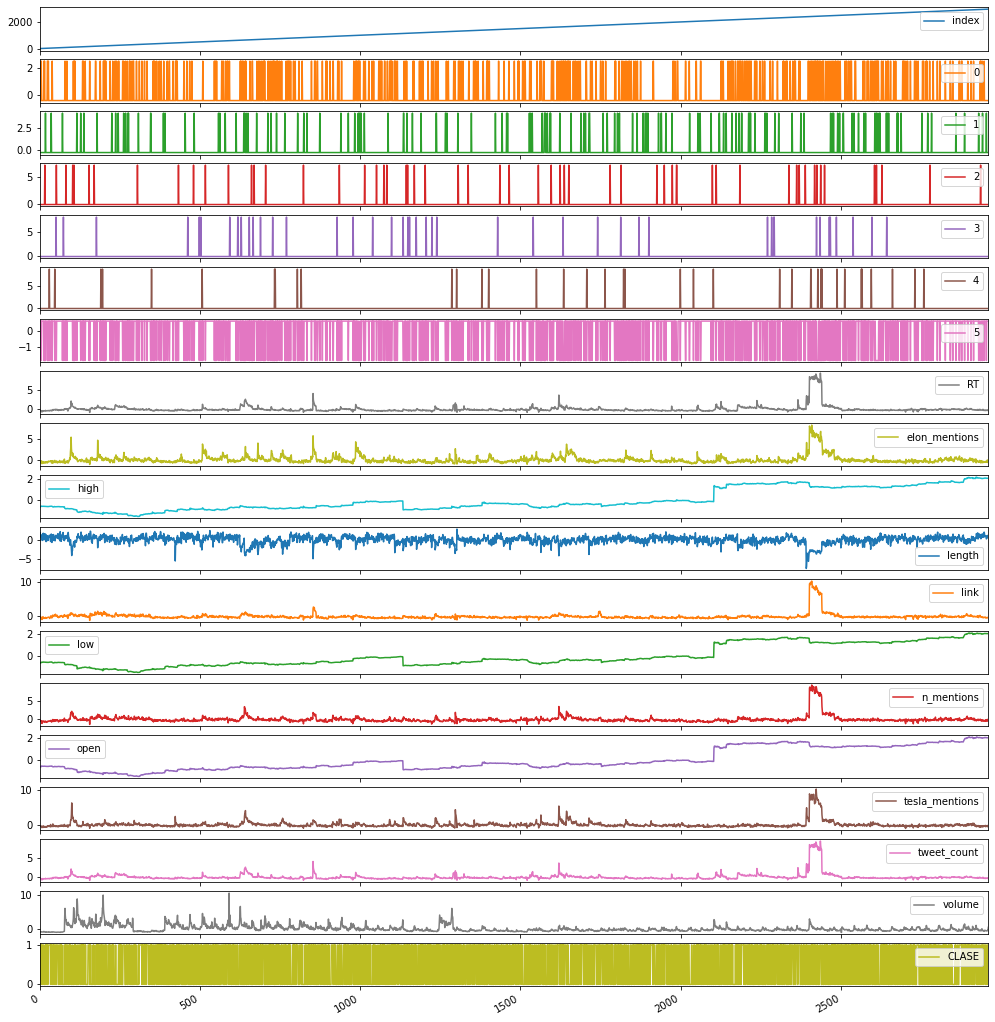

In [41]:
df.plot(figsize = (17,20), subplots=True)

In [42]:
df.drop(["index"], axis = 1, inplace = True)

In [43]:
df.head()

,0,1,2,3,4,5,RT,elon_mentions,high,length,link,low,n_mentions,open,tesla_mentions,tweet_count,volume,CLASE
0,-0.404299,-0.235828,-0.1401,-0.124226,-0.115529,0.563179,-0.502666,-0.778493,-0.594321,-0.082998,-0.461700,-0.629211,-0.198503,-0.591658,-0.337868,-0.502666,-1.056018,0
1,-0.404299,-0.235828,-0.1401,-0.124226,-0.115529,0.563179,-0.361431,-0.677337,-0.635504,1.848156,0.009630,-0.652687,-0.214925,-0.632892,-0.337868,-0.361431,-0.971722,0
2,-0.404299,-0.235828,-0.1401,-0.124226,-0.115529,0.563179,-0.385876,-0.711056,-0.625644,1.580100,-0.136645,-0.635389,-0.350400,-0.632381,-0.376520,-0.385876,-1.025667,1
3,-0.404299,-0.235828,-0.1401,-0.124226,-0.115529,0.563179,-0.388592,-0.677337,-0.607333,0.805683,-0.120392,-0.616679,-0.551562,-0.621614,-0.415173,-0.388592,-1.063525,1
4,-0.404299,-0.235828,-0.1401,-0.124226,-0.115529,0.563179,-0.442913,-0.475024,-0.563668,1.207537,-0.307299,-0.623740,-0.391454,-0.620575,-0.589110,-0.442913,-1.010545,1


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2961 entries, 0 to 2960
Data columns (total 18 columns):
0                 2961 non-null float64
1                 2961 non-null float64
2                 2961 non-null float64
3                 2961 non-null float64
4                 2961 non-null float64
5                 2961 non-null float64
RT                2961 non-null float64
elon_mentions     2961 non-null float64
high              2961 non-null float64
length            2961 non-null float64
link              2961 non-null float64
low               2961 non-null float64
n_mentions        2961 non-null float64
open              2961 non-null float64
tesla_mentions    2961 non-null float64
tweet_count       2961 non-null float64
volume            2961 non-null float64
CLASE             2961 non-null int64
dtypes: float64(17), int64(1)
memory usage: 416.5 KB


### Normalizaition

In [45]:
train_split = int(len(df)*0.7)
print(train_split)

2072


In [46]:
features = df.columns.difference(['CLASE']).tolist()

#dataset = df.values
x = df[features]#.values
y = df['CLASE'].values


In [47]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)

In [48]:
#standardizing the input feature
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x = sc.fit_transform(x)

In [49]:
x_train = x[:train_split]
y_train = y[:train_split]

x_val = x[train_split:]
y_val = y[train_split:]

### Split train-test

In [50]:
def make_model( recurrent_units
               , dense_units
               , target_size 
               , recurrent_layers 
               , recurrent_dropout 
               , dense_layers 
               , dense_droput 
               , lr 
               , verbose = 2):
    
    model = tf.keras.models.Sequential()
    
    #model.add(tf.keras.layers.Flatten())
    
    for i in range(0, recurrent_layers):
        # return_sequences -> last bidirectional doesnt return requences
        return_sequences = ((recurrent_layers - i) != 1)
        
        model.add(tf.keras.layers.LSTM(units = recurrent_units
                                        , input_shape = x_train.shape[-2:]
                                        , activation = 'relu'
                                        , dropout = recurrent_dropout
                                        , recurrent_dropout = recurrent_dropout
                                        , return_sequences = return_sequences
                                        ))
        
    #model.add(tf.keras.layers.Flatten())
    
    for i in range(0,dense_layers):
        model.add(tf.keras.layers.Dense(dense_units, activation='relu'))
        if dense_droput != 0.0:
            model.add(tf.keras.layers.Dropout(dense_droput))
    
    model.add(tf.keras.layers.Dense(target_size, activation='relu'))

    model.compile(loss = 'mse'
                    , optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
                    , metrics = ['mae'])
    if verbose:

        print(model.summary())
    
    return model

In [51]:
x_train = x_train.reshape(len(x_train), 1, len(df[features].columns))
x = x.reshape(len(x), 1, len(df[features].columns))

In [52]:
x_train.shape

(2072, 1, 17)

### Main grid search

In [57]:
recurrent_units = [x_train.shape[-1]]
dense_units = [x_train.shape[-1]]
target_size = [1]
recurrent_layers = [1,2,5]
recurrent_dropout = [0,0.3, 0.5]
dense_layers = [1,2,5]
dense_droput = [0,0.3, 0.5]
lr = [0.001]
optimizer = ['rmsprop']
epochs = [10, 20, 30]
batch_size = [16,32]

param_grid = dict(recurrent_units = recurrent_units
                   , dense_units = dense_units
                   , target_size = target_size
                   , recurrent_layers = recurrent_layers
                   , recurrent_dropout = recurrent_dropout
                   , dense_layers = dense_layers
                   , dense_droput = dense_droput
                   , lr = lr
              #    , optimizer = optimizer
                   , epochs = epochs
                   , batch_size = batch_size
                 )

model = KerasRegressor(build_fn = make_model
                       , verbose = 2)

grid = GridSearchCV(estimator = model
                    , param_grid = param_grid
                    , n_jobs = 1
                    , cv = 3 # cross validation
                    , scoring = 'neg_mean_absolute_error'
                    , return_train_score = True
                    , verbose = 2
                   )

In [ ]:
grid_result = grid.fit(x, y)

Fitting 3 folds for each of 486 candidates, totalling 1458 fits
[CV] batch_size=16, dense_droput=0, dense_layers=1, dense_units=17, epochs=10, lr=0.001, recurrent_dropout=0, recurrent_layers=1, recurrent_units=17, target_size=1 
Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_150 (LSTM)              (None, 17)                2380      
_________________________________________________________________
dense_118 (Dense)            (None, 17)                306       
_________________________________________________________________
dense_119 (Dense)            (None, 1)                 18        
Total params: 2,704
Trainable params: 2,704
Non-trainable params: 0
_________________________________________________________________
None


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train on 1974 samples
Epoch 1/10
1974/1974 - 11s - loss: 0.3184 - mean_absolute_error: 0.5121
Epoch 2/10
1974/1974 - 1s - loss: 0.2553 - mean_absolute_error: 0.5005
Epoch 3/10
1974/1974 - 1s - loss: 0.2514 - mean_absolute_error: 0.4983
Epoch 4/10
1974/1974 - 1s - loss: 0.2504 - mean_absolute_error: 0.4974
Epoch 5/10
1974/1974 - 1s - loss: 0.2493 - mean_absolute_error: 0.4958
Epoch 6/10
1974/1974 - 1s - loss: 0.2481 - mean_absolute_error: 0.4931
Epoch 7/10
1974/1974 - 1s - loss: 0.2485 - mean_absolute_error: 0.4945
Epoch 8/10
1974/1974 - 1s - loss: 0.2489 - mean_absolute_error: 0.4945
Epoch 9/10
1974/1974 - 1s - loss: 0.2482 - mean_absolute_error: 0.4942
Epoch 10/10
1974/1974 - 1s - loss: 0.2480 - mean_absolute_error: 0.4939
987/987 - 10s
1974/1974 - 0s
[CV]  batch_size=16, dense_droput=0, dense_layers=1, dense_units=17, epochs=10, lr=0.001, recurrent_dropout=0, recurrent_layers=1, recurrent_units=17, target_size=1, total= 1.1min
[CV] batch_size=16, dense_droput=0, dense_layers=1, dense

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


Train on 1974 samples
Epoch 1/10
1974/1974 - 11s - loss: 0.3099 - mean_absolute_error: 0.5104
Epoch 2/10
1974/1974 - 1s - loss: 0.2550 - mean_absolute_error: 0.4995
Epoch 3/10
1974/1974 - 1s - loss: 0.2510 - mean_absolute_error: 0.4962
Epoch 4/10
1974/1974 - 1s - loss: 0.2497 - mean_absolute_error: 0.4956
Epoch 5/10
1974/1974 - 1s - loss: 0.2482 - mean_absolute_error: 0.4943
Epoch 6/10
1974/1974 - 1s - loss: 0.2472 - mean_absolute_error: 0.4925
Epoch 7/10
1974/1974 - 1s - loss: 0.2463 - mean_absolute_error: 0.4915
Epoch 8/10
1974/1974 - 1s - loss: 0.2459 - mean_absolute_error: 0.4910
Epoch 9/10
1974/1974 - 1s - loss: 0.2456 - mean_absolute_error: 0.4906
Epoch 10/10
1974/1974 - 1s - loss: 0.2445 - mean_absolute_error: 0.4887
987/987 - 10s
1974/1974 - 0s
[CV]  batch_size=16, dense_droput=0, dense_layers=1, dense_units=17, epochs=10, lr=0.001, recurrent_dropout=0, recurrent_layers=1, recurrent_units=17, target_size=1, total= 1.1min
[CV] batch_size=16, dense_droput=0, dense_layers=1, dense

Epoch 6/10
1974/1974 - 1s - loss: 0.2491 - mean_absolute_error: 0.4962
Epoch 7/10
1974/1974 - 1s - loss: 0.2487 - mean_absolute_error: 0.4959
Epoch 8/10
1974/1974 - 1s - loss: 0.2485 - mean_absolute_error: 0.4962
Epoch 9/10
1974/1974 - 1s - loss: 0.2482 - mean_absolute_error: 0.4948
Epoch 10/10
1974/1974 - 1s - loss: 0.2478 - mean_absolute_error: 0.4950
987/987 - 11s
1974/1974 - 0s
[CV]  batch_size=16, dense_droput=0, dense_layers=1, dense_units=17, epochs=10, lr=0.001, recurrent_dropout=0, recurrent_layers=2, recurrent_units=17, target_size=1, total= 1.3min
[CV] batch_size=16, dense_droput=0, dense_layers=1, dense_units=17, epochs=10, lr=0.001, recurrent_dropout=0, recurrent_layers=5, recurrent_units=17, target_size=1 
Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_159 (LSTM)              (None, 1, 17)             2380      
_________________________________________________

Train on 1974 samples
Epoch 1/10
1974/1974 - 14s - loss: 0.2850 - mean_absolute_error: 0.5036
Epoch 2/10
1974/1974 - 1s - loss: 0.2619 - mean_absolute_error: 0.4999
Epoch 3/10
1974/1974 - 1s - loss: 0.2573 - mean_absolute_error: 0.4997
Epoch 4/10
1974/1974 - 1s - loss: 0.2534 - mean_absolute_error: 0.4970
Epoch 5/10
1974/1974 - 1s - loss: 0.2528 - mean_absolute_error: 0.4966
Epoch 6/10
1974/1974 - 1s - loss: 0.2548 - mean_absolute_error: 0.4996
Epoch 7/10
1974/1974 - 1s - loss: 0.2505 - mean_absolute_error: 0.4962
Epoch 8/10
1974/1974 - 1s - loss: 0.2529 - mean_absolute_error: 0.4988
Epoch 9/10
1974/1974 - 1s - loss: 0.2522 - mean_absolute_error: 0.4976
Epoch 10/10
1974/1974 - 1s - loss: 0.2524 - mean_absolute_error: 0.4987
987/987 - 12s
1974/1974 - 0s
[CV]  batch_size=16, dense_droput=0, dense_layers=1, dense_units=17, epochs=10, lr=0.001, recurrent_dropout=0.3, recurrent_layers=1, recurrent_units=17, target_size=1, total= 1.4min
[CV] batch_size=16, dense_droput=0, dense_layers=1, den

1974/1974 - 1s - loss: 0.2506 - mean_absolute_error: 0.4981
Epoch 8/10
1974/1974 - 1s - loss: 0.2494 - mean_absolute_error: 0.4970
Epoch 9/10
1974/1974 - 1s - loss: 0.2511 - mean_absolute_error: 0.4990
Epoch 10/10
1974/1974 - 1s - loss: 0.2503 - mean_absolute_error: 0.4978
987/987 - 15s
1974/1974 - 0s
[CV]  batch_size=16, dense_droput=0, dense_layers=1, dense_units=17, epochs=10, lr=0.001, recurrent_dropout=0.3, recurrent_layers=2, recurrent_units=17, target_size=1, total= 1.7min
[CV] batch_size=16, dense_droput=0, dense_layers=1, dense_units=17, epochs=10, lr=0.001, recurrent_dropout=0.3, recurrent_layers=2, recurrent_units=17, target_size=1 
Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_181 (LSTM)              (None, 1, 17)             2380      
_________________________________________________________________
lstm_182 (LSTM)              (None, 17)                2380  

Train on 1974 samples
Epoch 1/10
1974/1974 - 21s - loss: 0.3310 - mean_absolute_error: 0.5094
Epoch 2/10
1974/1974 - 2s - loss: 0.2514 - mean_absolute_error: 0.5006
Epoch 3/10
1974/1974 - 2s - loss: 0.2499 - mean_absolute_error: 0.4987
Epoch 4/10
1974/1974 - 2s - loss: 0.2507 - mean_absolute_error: 0.4999
Epoch 5/10
1974/1974 - 2s - loss: 0.2501 - mean_absolute_error: 0.4990
Epoch 6/10
1974/1974 - 2s - loss: 0.2502 - mean_absolute_error: 0.4992
Epoch 7/10
1974/1974 - 2s - loss: 0.2508 - mean_absolute_error: 0.5000
Epoch 8/10
1974/1974 - 2s - loss: 0.2504 - mean_absolute_error: 0.4993
Epoch 9/10
1974/1974 - 2s - loss: 0.2502 - mean_absolute_error: 0.4992
Epoch 10/10
1974/1974 - 2s - loss: 0.2508 - mean_absolute_error: 0.5000
987/987 - 16s
1974/1974 - 0s
[CV]  batch_size=16, dense_droput=0, dense_layers=1, dense_units=17, epochs=10, lr=0.001, recurrent_dropout=0.3, recurrent_layers=5, recurrent_units=17, target_size=1, total= 2.0min
[CV] batch_size=16, dense_droput=0, dense_layers=1, den

Epoch 9/10
1974/1974 - 1s - loss: 0.2513 - mean_absolute_error: 0.4999
Epoch 10/10
1974/1974 - 1s - loss: 0.2511 - mean_absolute_error: 0.4995
987/987 - 17s
1974/1974 - 0s
[CV]  batch_size=16, dense_droput=0, dense_layers=1, dense_units=17, epochs=10, lr=0.001, recurrent_dropout=0.5, recurrent_layers=2, recurrent_units=17, target_size=1, total= 1.9min
[CV] batch_size=16, dense_droput=0, dense_layers=1, dense_units=17, epochs=10, lr=0.001, recurrent_dropout=0.5, recurrent_layers=2, recurrent_units=17, target_size=1 
Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_203 (LSTM)              (None, 1, 17)             2380      
_________________________________________________________________
lstm_204 (LSTM)              (None, 17)                2380      
_________________________________________________________________
dense_162 (Dense)            (None, 17)                306  

Train on 1974 samples
Epoch 1/10
1974/1974 - 25s - loss: 0.3294 - mean_absolute_error: 0.4999
Epoch 2/10
1974/1974 - 3s - loss: 0.2510 - mean_absolute_error: 0.5004
Epoch 3/10
1974/1974 - 3s - loss: 0.2506 - mean_absolute_error: 0.4998
Epoch 4/10
1974/1974 - 3s - loss: 0.2512 - mean_absolute_error: 0.5007
Epoch 5/10
1974/1974 - 3s - loss: 0.2511 - mean_absolute_error: 0.5006
Epoch 6/10
1974/1974 - 3s - loss: 0.2509 - mean_absolute_error: 0.5005
Epoch 7/10
1974/1974 - 3s - loss: 0.2504 - mean_absolute_error: 0.4997
Epoch 8/10
1974/1974 - 3s - loss: 0.2506 - mean_absolute_error: 0.4993
Epoch 9/10
1974/1974 - 3s - loss: 0.2505 - mean_absolute_error: 0.4999
Epoch 10/10
1974/1974 - 3s - loss: 0.2505 - mean_absolute_error: 0.4999
987/987 - 20s
1974/1974 - 0s
[CV]  batch_size=16, dense_droput=0, dense_layers=1, dense_units=17, epochs=10, lr=0.001, recurrent_dropout=0.5, recurrent_layers=5, recurrent_units=17, target_size=1, total= 2.4min
[CV] batch_size=16, dense_droput=0, dense_layers=1, den

Epoch 20/20
1974/1974 - 1s - loss: 0.2411 - mean_absolute_error: 0.4817
987/987 - 21s
1974/1974 - 0s
[CV]  batch_size=16, dense_droput=0, dense_layers=1, dense_units=17, epochs=20, lr=0.001, recurrent_dropout=0, recurrent_layers=1, recurrent_units=17, target_size=1, total= 2.4min
[CV] batch_size=16, dense_droput=0, dense_layers=1, dense_units=17, epochs=20, lr=0.001, recurrent_dropout=0, recurrent_layers=1, recurrent_units=17, target_size=1 
Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_224 (LSTM)              (None, 17)                2380      
_________________________________________________________________
dense_176 (Dense)            (None, 17)                306       
_________________________________________________________________
dense_177 (Dense)            (None, 1)                 18        
Total params: 2,704
Trainable params: 2,704
Non-trainable params: 0
_

Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_229 (LSTM)              (None, 1, 17)             2380      
_________________________________________________________________
lstm_230 (LSTM)              (None, 17)                2380      
_________________________________________________________________
dense_182 (Dense)            (None, 17)                306       
_________________________________________________________________
dense_183 (Dense)            (None, 1)                 18        
Total params: 5,084
Trainable params: 5,084
Non-trainable params: 0
_________________________________________________________________
None
Train on 1974 samples
Epoch 1/20
1974/1974 - 25s - loss: 0.3405 - mean_absolute_error: 0.5095
Epoch 2/20
1974/1974 - 1s - loss: 0.2516 - mean_absolute_error: 0.4970
Epoch 3/20
1974/1974 - 1s - loss: 0.2500 - mean_absolute_error: 0.4961
Epoch 4/

Epoch 16/20
1974/1974 - 2s - loss: 0.2472 - mean_absolute_error: 0.4927
Epoch 17/20
1974/1974 - 2s - loss: 0.2467 - mean_absolute_error: 0.4915
Epoch 18/20
1974/1974 - 2s - loss: 0.2467 - mean_absolute_error: 0.4920
Epoch 19/20
1974/1974 - 2s - loss: 0.2472 - mean_absolute_error: 0.4918
Epoch 20/20
1974/1974 - 2s - loss: 0.2454 - mean_absolute_error: 0.4900
987/987 - 23s
1974/1974 - 0s
[CV]  batch_size=16, dense_droput=0, dense_layers=1, dense_units=17, epochs=20, lr=0.001, recurrent_dropout=0, recurrent_layers=5, recurrent_units=17, target_size=1, total= 3.0min
[CV] batch_size=16, dense_droput=0, dense_layers=1, dense_units=17, epochs=20, lr=0.001, recurrent_dropout=0, recurrent_layers=5, recurrent_units=17, target_size=1 
Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_241 (LSTM)              (None, 1, 17)             2380      
_____________________________________________

Epoch 15/20
1974/1974 - 1s - loss: 0.2492 - mean_absolute_error: 0.4933
Epoch 16/20
1974/1974 - 1s - loss: 0.2475 - mean_absolute_error: 0.4913
Epoch 17/20
1974/1974 - 1s - loss: 0.2493 - mean_absolute_error: 0.4936
Epoch 18/20
1974/1974 - 1s - loss: 0.2483 - mean_absolute_error: 0.4928
Epoch 19/20
1974/1974 - 1s - loss: 0.2500 - mean_absolute_error: 0.4942
Epoch 20/20
1974/1974 - 1s - loss: 0.2497 - mean_absolute_error: 0.4942
987/987 - 26s
1974/1974 - 0s
[CV]  batch_size=16, dense_droput=0, dense_layers=1, dense_units=17, epochs=20, lr=0.001, recurrent_dropout=0.3, recurrent_layers=1, recurrent_units=17, target_size=1, total= 2.8min
[CV] batch_size=16, dense_droput=0, dense_layers=1, dense_units=17, epochs=20, lr=0.001, recurrent_dropout=0.3, recurrent_layers=1, recurrent_units=17, target_size=1 
Model: "sequential_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_248 (LSTM)              (None,

Epoch 18/20
1974/1974 - 2s - loss: 0.2506 - mean_absolute_error: 0.4986
Epoch 19/20
1974/1974 - 2s - loss: 0.2480 - mean_absolute_error: 0.4953
Epoch 20/20
1974/1974 - 2s - loss: 0.2500 - mean_absolute_error: 0.4969
987/987 - 25s
1974/1974 - 0s
[CV]  batch_size=16, dense_droput=0, dense_layers=1, dense_units=17, epochs=20, lr=0.001, recurrent_dropout=0.3, recurrent_layers=2, recurrent_units=17, target_size=1, total= 2.9min
[CV] batch_size=16, dense_droput=0, dense_layers=1, dense_units=17, epochs=20, lr=0.001, recurrent_dropout=0.3, recurrent_layers=2, recurrent_units=17, target_size=1 
Model: "sequential_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_253 (LSTM)              (None, 1, 17)             2380      
_________________________________________________________________
lstm_254 (LSTM)              (None, 17)                2380      
____________________________________________________

Epoch 8/20
1974/1974 - 3s - loss: 0.5046 - mean_absolute_error: 0.5046
Epoch 9/20
1974/1974 - 3s - loss: 0.5046 - mean_absolute_error: 0.5046
Epoch 10/20
1974/1974 - 3s - loss: 0.5046 - mean_absolute_error: 0.5046
Epoch 11/20
1974/1974 - 3s - loss: 0.5046 - mean_absolute_error: 0.5046
Epoch 12/20
1974/1974 - 3s - loss: 0.5046 - mean_absolute_error: 0.5046
Epoch 13/20
1974/1974 - 3s - loss: 0.5046 - mean_absolute_error: 0.5046
Epoch 14/20
1974/1974 - 3s - loss: 0.5046 - mean_absolute_error: 0.5046
Epoch 15/20
1974/1974 - 3s - loss: 0.5046 - mean_absolute_error: 0.5046
Epoch 16/20
1974/1974 - 3s - loss: 0.5046 - mean_absolute_error: 0.5046
Epoch 17/20
1974/1974 - 3s - loss: 0.5046 - mean_absolute_error: 0.5046
Epoch 18/20
1974/1974 - 3s - loss: 0.5046 - mean_absolute_error: 0.5046
Epoch 19/20
1974/1974 - 3s - loss: 0.5046 - mean_absolute_error: 0.5046
Epoch 20/20
1974/1974 - 3s - loss: 0.5046 - mean_absolute_error: 0.5046
987/987 - 30s
1974/1974 - 1s
[CV]  batch_size=16, dense_droput=0, 

Epoch 7/20
1974/1974 - 1s - loss: 0.2551 - mean_absolute_error: 0.5008
Epoch 8/20
1974/1974 - 1s - loss: 0.2545 - mean_absolute_error: 0.5002
Epoch 9/20
1974/1974 - 1s - loss: 0.2524 - mean_absolute_error: 0.4989
Epoch 10/20
1974/1974 - 1s - loss: 0.2509 - mean_absolute_error: 0.4976
Epoch 11/20
1974/1974 - 1s - loss: 0.2495 - mean_absolute_error: 0.4961
Epoch 12/20
1974/1974 - 1s - loss: 0.2507 - mean_absolute_error: 0.4969
Epoch 13/20
1974/1974 - 1s - loss: 0.2520 - mean_absolute_error: 0.4982
Epoch 14/20
1974/1974 - 1s - loss: 0.2496 - mean_absolute_error: 0.4959
Epoch 15/20
1974/1974 - 1s - loss: 0.2492 - mean_absolute_error: 0.4960
Epoch 16/20
1974/1974 - 1s - loss: 0.2523 - mean_absolute_error: 0.4996
Epoch 17/20
1974/1974 - 1s - loss: 0.2496 - mean_absolute_error: 0.4964
Epoch 18/20
1974/1974 - 1s - loss: 0.2496 - mean_absolute_error: 0.4964
Epoch 19/20
1974/1974 - 1s - loss: 0.2497 - mean_absolute_error: 0.4970
Epoch 20/20
1974/1974 - 1s - loss: 0.2497 - mean_absolute_error: 0.

Epoch 10/20
1974/1974 - 2s - loss: 0.2514 - mean_absolute_error: 0.5003
Epoch 11/20
1974/1974 - 2s - loss: 0.2510 - mean_absolute_error: 0.4997
Epoch 12/20
1974/1974 - 2s - loss: 0.2505 - mean_absolute_error: 0.4991
Epoch 13/20
1974/1974 - 2s - loss: 0.2499 - mean_absolute_error: 0.4988
Epoch 14/20
1974/1974 - 2s - loss: 0.2510 - mean_absolute_error: 0.4996
Epoch 15/20
1974/1974 - 2s - loss: 0.2505 - mean_absolute_error: 0.4993
Epoch 16/20
1974/1974 - 2s - loss: 0.2496 - mean_absolute_error: 0.4983
Epoch 17/20
1974/1974 - 2s - loss: 0.2502 - mean_absolute_error: 0.4989
Epoch 18/20
1974/1974 - 2s - loss: 0.2505 - mean_absolute_error: 0.4990
Epoch 19/20
1974/1974 - 2s - loss: 0.2504 - mean_absolute_error: 0.4990
Epoch 20/20
1974/1974 - 2s - loss: 0.2492 - mean_absolute_error: 0.4975
987/987 - 34s
1974/1974 - 0s
[CV]  batch_size=16, dense_droput=0, dense_layers=1, dense_units=17, epochs=20, lr=0.001, recurrent_dropout=0.5, recurrent_layers=2, recurrent_units=17, target_size=1, total= 3.9m

Train on 1974 samples
Epoch 1/20
1974/1974 - 42s - loss: 0.3034 - mean_absolute_error: 0.4971
Epoch 2/20
1974/1974 - 4s - loss: 0.2508 - mean_absolute_error: 0.5001
Epoch 3/20
1974/1974 - 4s - loss: 0.2508 - mean_absolute_error: 0.5000
Epoch 4/20
1974/1974 - 4s - loss: 0.2509 - mean_absolute_error: 0.5002
Epoch 5/20
1974/1974 - 4s - loss: 0.2506 - mean_absolute_error: 0.4997
Epoch 6/20
1974/1974 - 4s - loss: 0.2513 - mean_absolute_error: 0.5007
Epoch 7/20
1974/1974 - 4s - loss: 0.2509 - mean_absolute_error: 0.5004
Epoch 8/20
1974/1974 - 4s - loss: 0.2508 - mean_absolute_error: 0.5002
Epoch 9/20
1974/1974 - 4s - loss: 0.2511 - mean_absolute_error: 0.5008
Epoch 10/20
1974/1974 - 4s - loss: 0.2508 - mean_absolute_error: 0.5002
Epoch 11/20
1974/1974 - 4s - loss: 0.2510 - mean_absolute_error: 0.5007
Epoch 12/20
1974/1974 - 4s - loss: 0.2507 - mean_absolute_error: 0.5002
Epoch 13/20
1974/1974 - 4s - loss: 0.2506 - mean_absolute_error: 0.5000
Epoch 14/20
1974/1974 - 4s - loss: 0.2502 - mean_a

lstm_295 (LSTM)              (None, 17)                2380      
_________________________________________________________________
dense_228 (Dense)            (None, 17)                306       
_________________________________________________________________
dense_229 (Dense)            (None, 1)                 18        
Total params: 2,704
Trainable params: 2,704
Non-trainable params: 0
_________________________________________________________________
None
Train on 1974 samples
Epoch 1/30
1974/1974 - 39s - loss: 0.2937 - mean_absolute_error: 0.5039
Epoch 2/30
1974/1974 - 1s - loss: 0.2547 - mean_absolute_error: 0.4982
Epoch 3/30
1974/1974 - 1s - loss: 0.2516 - mean_absolute_error: 0.4967
Epoch 4/30
1974/1974 - 1s - loss: 0.2495 - mean_absolute_error: 0.4945
Epoch 5/30
1974/1974 - 1s - loss: 0.2485 - mean_absolute_error: 0.4936
Epoch 6/30
1974/1974 - 1s - loss: 0.2480 - mean_absolute_error: 0.4933
Epoch 7/30
1974/1974 - 1s - loss: 0.2467 - mean_absolute_error: 0.4911
Epoch 8/30


Epoch 13/30
1974/1974 - 2s - loss: 0.2465 - mean_absolute_error: 0.4921
Epoch 14/30
1974/1974 - 2s - loss: 0.2469 - mean_absolute_error: 0.4922
Epoch 15/30
1974/1974 - 2s - loss: 0.2463 - mean_absolute_error: 0.4913
Epoch 16/30
1974/1974 - 2s - loss: 0.2463 - mean_absolute_error: 0.4913
Epoch 17/30
1974/1974 - 2s - loss: 0.2457 - mean_absolute_error: 0.4902
Epoch 18/30
1974/1974 - 2s - loss: 0.2456 - mean_absolute_error: 0.4905
Epoch 19/30
1974/1974 - 2s - loss: 0.2450 - mean_absolute_error: 0.4893
Epoch 20/30
1974/1974 - 2s - loss: 0.2444 - mean_absolute_error: 0.4884
Epoch 21/30
1974/1974 - 2s - loss: 0.2444 - mean_absolute_error: 0.4885
Epoch 22/30
1974/1974 - 2s - loss: 0.2439 - mean_absolute_error: 0.4878
Epoch 23/30
1974/1974 - 2s - loss: 0.2435 - mean_absolute_error: 0.4867
Epoch 24/30
1974/1974 - 2s - loss: 0.2434 - mean_absolute_error: 0.4865
Epoch 25/30
1974/1974 - 2s - loss: 0.2429 - mean_absolute_error: 0.4854
Epoch 26/30
1974/1974 - 2s - loss: 0.2421 - mean_absolute_error:

[CV]  batch_size=16, dense_droput=0, dense_layers=1, dense_units=17, epochs=30, lr=0.001, recurrent_dropout=0, recurrent_layers=2, recurrent_units=17, target_size=1, total= 4.6min
[CV] batch_size=16, dense_droput=0, dense_layers=1, dense_units=17, epochs=30, lr=0.001, recurrent_dropout=0, recurrent_layers=5, recurrent_units=17, target_size=1 
Model: "sequential_119"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_303 (LSTM)              (None, 1, 17)             2380      
_________________________________________________________________
lstm_304 (LSTM)              (None, 1, 17)             2380      
_________________________________________________________________
lstm_305 (LSTM)              (None, 1, 17)             2380      
_________________________________________________________________
lstm_306 (LSTM)              (None, 1, 17)             2380      
_____________________________________

Train on 1974 samples
Epoch 1/30
1974/1974 - 49s - loss: 0.3260 - mean_absolute_error: 0.5019
Epoch 2/30
1974/1974 - 3s - loss: 0.2510 - mean_absolute_error: 0.4988
Epoch 3/30
1974/1974 - 3s - loss: 0.2497 - mean_absolute_error: 0.4979
Epoch 4/30
1974/1974 - 3s - loss: 0.2505 - mean_absolute_error: 0.4986
Epoch 5/30
1974/1974 - 3s - loss: 0.2497 - mean_absolute_error: 0.4977
Epoch 6/30
1974/1974 - 3s - loss: 0.2494 - mean_absolute_error: 0.4975
Epoch 7/30
1974/1974 - 3s - loss: 0.2492 - mean_absolute_error: 0.4975
Epoch 8/30
1974/1974 - 3s - loss: 0.2493 - mean_absolute_error: 0.4972
Epoch 9/30
1974/1974 - 3s - loss: 0.2487 - mean_absolute_error: 0.4961
Epoch 10/30
1974/1974 - 3s - loss: 0.2489 - mean_absolute_error: 0.4965
Epoch 11/30
1974/1974 - 3s - loss: 0.2487 - mean_absolute_error: 0.4962
Epoch 12/30
1974/1974 - 3s - loss: 0.2482 - mean_absolute_error: 0.4953
Epoch 13/30
1974/1974 - 3s - loss: 0.2483 - mean_absolute_error: 0.4952
Epoch 14/30
1974/1974 - 3s - loss: 0.2483 - mean_a

Epoch 23/30
1974/1974 - 1s - loss: 0.2474 - mean_absolute_error: 0.4928
Epoch 24/30
1974/1974 - 2s - loss: 0.2470 - mean_absolute_error: 0.4930
Epoch 25/30
1974/1974 - 1s - loss: 0.2463 - mean_absolute_error: 0.4914
Epoch 26/30
1974/1974 - 1s - loss: 0.2478 - mean_absolute_error: 0.4930
Epoch 27/30
1974/1974 - 2s - loss: 0.2474 - mean_absolute_error: 0.4923
Epoch 28/30
1974/1974 - 2s - loss: 0.2451 - mean_absolute_error: 0.4904
Epoch 29/30
1974/1974 - 1s - loss: 0.2479 - mean_absolute_error: 0.4928
Epoch 30/30
1974/1974 - 1s - loss: 0.2483 - mean_absolute_error: 0.4935
987/987 - 46s
1974/1974 - 0s
[CV]  batch_size=16, dense_droput=0, dense_layers=1, dense_units=17, epochs=30, lr=0.001, recurrent_dropout=0.3, recurrent_layers=1, recurrent_units=17, target_size=1, total= 5.0min
[CV] batch_size=16, dense_droput=0, dense_layers=1, dense_units=17, epochs=30, lr=0.001, recurrent_dropout=0.3, recurrent_layers=1, recurrent_units=17, target_size=1 
Model: "sequential_124"
______________________

Train on 1974 samples
Epoch 1/30
1974/1974 - 50s - loss: 0.3109 - mean_absolute_error: 0.5060
Epoch 2/30
1974/1974 - 2s - loss: 0.2527 - mean_absolute_error: 0.4999
Epoch 3/30
1974/1974 - 2s - loss: 0.2507 - mean_absolute_error: 0.4983
Epoch 4/30
1974/1974 - 2s - loss: 0.2517 - mean_absolute_error: 0.4989
Epoch 5/30
1974/1974 - 2s - loss: 0.2506 - mean_absolute_error: 0.4989
Epoch 6/30
1974/1974 - 2s - loss: 0.2512 - mean_absolute_error: 0.4991
Epoch 7/30
1974/1974 - 2s - loss: 0.2511 - mean_absolute_error: 0.4990
Epoch 8/30
1974/1974 - 2s - loss: 0.2502 - mean_absolute_error: 0.4986
Epoch 9/30
1974/1974 - 2s - loss: 0.2481 - mean_absolute_error: 0.4953
Epoch 10/30
1974/1974 - 2s - loss: 0.2499 - mean_absolute_error: 0.4977
Epoch 11/30
1974/1974 - 2s - loss: 0.2491 - mean_absolute_error: 0.4968
Epoch 12/30
1974/1974 - 2s - loss: 0.2494 - mean_absolute_error: 0.4966
Epoch 13/30
1974/1974 - 2s - loss: 0.2490 - mean_absolute_error: 0.4968
Epoch 14/30
1974/1974 - 2s - loss: 0.2477 - mean_a

Epoch 14/30
1974/1974 - 4s - loss: 0.2502 - mean_absolute_error: 0.4992
Epoch 15/30
1974/1974 - 4s - loss: 0.2502 - mean_absolute_error: 0.4993
Epoch 16/30
1974/1974 - 4s - loss: 0.2500 - mean_absolute_error: 0.4987
Epoch 17/30
1974/1974 - 4s - loss: 0.2503 - mean_absolute_error: 0.4989
Epoch 18/30
1974/1974 - 4s - loss: 0.2501 - mean_absolute_error: 0.4987
Epoch 19/30
1974/1974 - 4s - loss: 0.2507 - mean_absolute_error: 0.4988
Epoch 20/30
1974/1974 - 4s - loss: 0.2516 - mean_absolute_error: 0.5001
Epoch 21/30
1974/1974 - 4s - loss: 0.2500 - mean_absolute_error: 0.4991
Epoch 22/30
1974/1974 - 4s - loss: 0.2496 - mean_absolute_error: 0.4986
Epoch 23/30
1974/1974 - 4s - loss: 0.2517 - mean_absolute_error: 0.4999
Epoch 24/30
1974/1974 - 4s - loss: 0.2495 - mean_absolute_error: 0.4981
Epoch 25/30
1974/1974 - 4s - loss: 0.2496 - mean_absolute_error: 0.4980
Epoch 26/30
1974/1974 - 4s - loss: 0.2499 - mean_absolute_error: 0.4984
Epoch 27/30
1974/1974 - 4s - loss: 0.2501 - mean_absolute_error:

1974/1974 - 5s - loss: 0.2506 - mean_absolute_error: 0.5000
Epoch 22/30
1974/1974 - 5s - loss: 0.2501 - mean_absolute_error: 0.4991
Epoch 23/30
1974/1974 - 5s - loss: 0.2504 - mean_absolute_error: 0.4994
Epoch 24/30
1974/1974 - 5s - loss: 0.2507 - mean_absolute_error: 0.4997
Epoch 25/30
1974/1974 - 4s - loss: 0.2502 - mean_absolute_error: 0.4991
Epoch 26/30
1974/1974 - 4s - loss: 0.2499 - mean_absolute_error: 0.4985
Epoch 27/30
1974/1974 - 5s - loss: 0.2503 - mean_absolute_error: 0.4988
Epoch 28/30
1974/1974 - 5s - loss: 0.2539 - mean_absolute_error: 0.4981
Epoch 29/30
1974/1974 - 5s - loss: 0.2498 - mean_absolute_error: 0.4979
Epoch 30/30
1974/1974 - 5s - loss: 0.2613 - mean_absolute_error: 0.4980
987/987 - 53s
1974/1974 - 1s
[CV]  batch_size=16, dense_droput=0, dense_layers=1, dense_units=17, epochs=30, lr=0.001, recurrent_dropout=0.3, recurrent_layers=5, recurrent_units=17, target_size=1, total= 7.2min
[CV] batch_size=16, dense_droput=0, dense_layers=1, dense_units=17, epochs=30, lr

Train on 1974 samples
Epoch 1/30
1974/1974 - 56s - loss: 0.2940 - mean_absolute_error: 0.5089
Epoch 2/30
1974/1974 - 2s - loss: 0.2575 - mean_absolute_error: 0.4970
Epoch 3/30
1974/1974 - 2s - loss: 0.2583 - mean_absolute_error: 0.5002
Epoch 4/30
1974/1974 - 2s - loss: 0.2517 - mean_absolute_error: 0.4947
Epoch 5/30
1974/1974 - 2s - loss: 0.2526 - mean_absolute_error: 0.4967
Epoch 6/30
1974/1974 - 2s - loss: 0.2517 - mean_absolute_error: 0.4948
Epoch 7/30
1974/1974 - 2s - loss: 0.2532 - mean_absolute_error: 0.4987
Epoch 8/30
1974/1974 - 2s - loss: 0.2519 - mean_absolute_error: 0.4973
Epoch 9/30
1974/1974 - 2s - loss: 0.2521 - mean_absolute_error: 0.4981
Epoch 10/30
1974/1974 - 2s - loss: 0.2508 - mean_absolute_error: 0.4974
Epoch 11/30
1974/1974 - 2s - loss: 0.2517 - mean_absolute_error: 0.4986
Epoch 12/30
1974/1974 - 2s - loss: 0.2503 - mean_absolute_error: 0.4975
Epoch 13/30
1974/1974 - 2s - loss: 0.2514 - mean_absolute_error: 0.4985
Epoch 14/30
1974/1974 - 2s - loss: 0.2499 - mean_a

1974/1974 - 3s - loss: 0.2491 - mean_absolute_error: 0.4973
Epoch 20/30
1974/1974 - 3s - loss: 0.2504 - mean_absolute_error: 0.4984
Epoch 21/30
1974/1974 - 3s - loss: 0.2507 - mean_absolute_error: 0.4989
Epoch 22/30
1974/1974 - 3s - loss: 0.2504 - mean_absolute_error: 0.4982
Epoch 23/30
1974/1974 - 3s - loss: 0.2505 - mean_absolute_error: 0.4989
Epoch 24/30
1974/1974 - 3s - loss: 0.2482 - mean_absolute_error: 0.4958
Epoch 25/30
1974/1974 - 3s - loss: 0.2519 - mean_absolute_error: 0.4995
Epoch 26/30
1974/1974 - 3s - loss: 0.2499 - mean_absolute_error: 0.4976
Epoch 27/30
1974/1974 - 3s - loss: 0.2497 - mean_absolute_error: 0.4977
Epoch 28/30
1974/1974 - 2s - loss: 0.2509 - mean_absolute_error: 0.4990
Epoch 29/30
1974/1974 - 2s - loss: 0.2512 - mean_absolute_error: 0.4997
Epoch 30/30
1974/1974 - 3s - loss: 0.2501 - mean_absolute_error: 0.4979
987/987 - 57s
1974/1974 - 1s
[CV]  batch_size=16, dense_droput=0, dense_layers=1, dense_units=17, epochs=30, lr=0.001, recurrent_dropout=0.5, recurr

Model: "sequential_138"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_356 (LSTM)              (None, 1, 17)             2380      
_________________________________________________________________
lstm_357 (LSTM)              (None, 1, 17)             2380      
_________________________________________________________________
lstm_358 (LSTM)              (None, 1, 17)             2380      
_________________________________________________________________
lstm_359 (LSTM)              (None, 1, 17)             2380      
_________________________________________________________________
lstm_360 (LSTM)              (None, 17)                2380      
_________________________________________________________________
dense_276 (Dense)            (None, 17)                306       
_________________________________________________________________
dense_277 (Dense)            (None, 1)              

Train on 1974 samples
Epoch 1/10
1974/1974 - 62s - loss: 0.2903 - mean_absolute_error: 0.5029
Epoch 2/10
1974/1974 - 2s - loss: 0.2533 - mean_absolute_error: 0.4975
Epoch 3/10
1974/1974 - 2s - loss: 0.2512 - mean_absolute_error: 0.4966
Epoch 4/10
1974/1974 - 2s - loss: 0.2501 - mean_absolute_error: 0.4950
Epoch 5/10
1974/1974 - 2s - loss: 0.2493 - mean_absolute_error: 0.4945
Epoch 6/10
1974/1974 - 2s - loss: 0.2484 - mean_absolute_error: 0.4942
Epoch 7/10
1974/1974 - 2s - loss: 0.2475 - mean_absolute_error: 0.4922
Epoch 8/10
1974/1974 - 2s - loss: 0.2471 - mean_absolute_error: 0.4924
Epoch 9/10
1974/1974 - 2s - loss: 0.2471 - mean_absolute_error: 0.4918
Epoch 10/10
1974/1974 - 2s - loss: 0.2468 - mean_absolute_error: 0.4914
987/987 - 62s
1974/1974 - 1s
[CV]  batch_size=16, dense_droput=0, dense_layers=2, dense_units=17, epochs=10, lr=0.001, recurrent_dropout=0, recurrent_layers=1, recurrent_units=17, target_size=1, total= 5.9min
[CV] batch_size=16, dense_droput=0, dense_layers=2, dense

Train on 1974 samples
Epoch 1/10
1974/1974 - 66s - loss: 0.2822 - mean_absolute_error: 0.5009
Epoch 2/10
1974/1974 - 2s - loss: 0.2505 - mean_absolute_error: 0.4991
Epoch 3/10
1974/1974 - 2s - loss: 0.2501 - mean_absolute_error: 0.4988
Epoch 4/10
1974/1974 - 2s - loss: 0.2498 - mean_absolute_error: 0.4983
Epoch 5/10
1974/1974 - 2s - loss: 0.2493 - mean_absolute_error: 0.4972
Epoch 6/10
1974/1974 - 2s - loss: 0.2491 - mean_absolute_error: 0.4966
Epoch 7/10
1974/1974 - 2s - loss: 0.2490 - mean_absolute_error: 0.4968
Epoch 8/10
1974/1974 - 2s - loss: 0.2478 - mean_absolute_error: 0.4951
Epoch 9/10
1974/1974 - 2s - loss: 0.2471 - mean_absolute_error: 0.4927
Epoch 10/10
1974/1974 - 2s - loss: 0.2474 - mean_absolute_error: 0.4935
987/987 - 65s
1974/1974 - 1s
[CV]  batch_size=16, dense_droput=0, dense_layers=2, dense_units=17, epochs=10, lr=0.001, recurrent_dropout=0, recurrent_layers=2, recurrent_units=17, target_size=1, total= 6.2min
[CV] batch_size=16, dense_droput=0, dense_layers=2, dense

Model: "sequential_148"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_385 (LSTM)              (None, 1, 17)             2380      
_________________________________________________________________
lstm_386 (LSTM)              (None, 1, 17)             2380      
_________________________________________________________________
lstm_387 (LSTM)              (None, 1, 17)             2380      
_________________________________________________________________
lstm_388 (LSTM)              (None, 1, 17)             2380      
_________________________________________________________________
lstm_389 (LSTM)              (None, 17)                2380      
_________________________________________________________________
dense_304 (Dense)            (None, 17)                306       
_________________________________________________________________
dense_305 (Dense)            (None, 17)             

Model: "sequential_152"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_393 (LSTM)              (None, 1, 17)             2380      
_________________________________________________________________
lstm_394 (LSTM)              (None, 17)                2380      
_________________________________________________________________
dense_316 (Dense)            (None, 17)                306       
_________________________________________________________________
dense_317 (Dense)            (None, 17)                306       
_________________________________________________________________
dense_318 (Dense)            (None, 1)                 18        
Total params: 5,390
Trainable params: 5,390
Non-trainable params: 0
_________________________________________________________________
None
Train on 1974 samples
Epoch 1/10
1974/1974 - 74s - loss: 0.2821 - mean_absolute_error: 0.5017
Epoch 2/10
1974/1

Epoch 6/10
1974/1974 - 5s - loss: 0.2504 - mean_absolute_error: 0.4995
Epoch 7/10
1974/1974 - 5s - loss: 0.2504 - mean_absolute_error: 0.4996
Epoch 8/10
1974/1974 - 5s - loss: 0.2506 - mean_absolute_error: 0.4998
Epoch 9/10
1974/1974 - 5s - loss: 0.2500 - mean_absolute_error: 0.4986
Epoch 10/10
1974/1974 - 5s - loss: 0.2495 - mean_absolute_error: 0.4981
987/987 - 75s
1974/1974 - 1s
[CV]  batch_size=16, dense_droput=0, dense_layers=2, dense_units=17, epochs=10, lr=0.001, recurrent_dropout=0.3, recurrent_layers=5, recurrent_units=17, target_size=1, total= 7.7min
[CV] batch_size=16, dense_droput=0, dense_layers=2, dense_units=17, epochs=10, lr=0.001, recurrent_dropout=0.3, recurrent_layers=5, recurrent_units=17, target_size=1 
Model: "sequential_156"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_404 (LSTM)              (None, 1, 17)             2380      
____________________________________________

Train on 1974 samples
Epoch 1/10
1974/1974 - 81s - loss: 0.3073 - mean_absolute_error: 0.5031
Epoch 2/10
1974/1974 - 2s - loss: 0.2622 - mean_absolute_error: 0.5033
Epoch 3/10
1974/1974 - 2s - loss: 0.2548 - mean_absolute_error: 0.4978
Epoch 4/10
1974/1974 - 2s - loss: 0.2528 - mean_absolute_error: 0.4976
Epoch 5/10
1974/1974 - 2s - loss: 0.2522 - mean_absolute_error: 0.4974
Epoch 6/10
1974/1974 - 2s - loss: 0.2522 - mean_absolute_error: 0.4986
Epoch 7/10
1974/1974 - 2s - loss: 0.2515 - mean_absolute_error: 0.4976
Epoch 8/10
1974/1974 - 2s - loss: 0.2508 - mean_absolute_error: 0.4972
Epoch 9/10
1974/1974 - 2s - loss: 0.2502 - mean_absolute_error: 0.4961
Epoch 10/10
1974/1974 - 2s - loss: 0.2509 - mean_absolute_error: 0.4971
987/987 - 80s
1974/1974 - 1s
[CV]  batch_size=16, dense_droput=0, dense_layers=2, dense_units=17, epochs=10, lr=0.001, recurrent_dropout=0.5, recurrent_layers=1, recurrent_units=17, target_size=1, total= 7.6min
[CV] batch_size=16, dense_droput=0, dense_layers=2, den

Train on 1974 samples
Epoch 1/10
1974/1974 - 86s - loss: 0.2874 - mean_absolute_error: 0.5055
Epoch 2/10
1974/1974 - 3s - loss: 0.2509 - mean_absolute_error: 0.4976
Epoch 3/10
1974/1974 - 3s - loss: 0.2506 - mean_absolute_error: 0.4983
Epoch 4/10
1974/1974 - 3s - loss: 0.2510 - mean_absolute_error: 0.4993
Epoch 5/10
1974/1974 - 3s - loss: 0.2514 - mean_absolute_error: 0.4997
Epoch 6/10
1974/1974 - 3s - loss: 0.2507 - mean_absolute_error: 0.4990
Epoch 7/10
1974/1974 - 3s - loss: 0.2501 - mean_absolute_error: 0.4985
Epoch 8/10
1974/1974 - 3s - loss: 0.2508 - mean_absolute_error: 0.4990
Epoch 9/10
1974/1974 - 3s - loss: 0.2507 - mean_absolute_error: 0.4991
Epoch 10/10
1974/1974 - 3s - loss: 0.2505 - mean_absolute_error: 0.4989
987/987 - 83s
1974/1974 - 1s
[CV]  batch_size=16, dense_droput=0, dense_layers=2, dense_units=17, epochs=10, lr=0.001, recurrent_dropout=0.5, recurrent_layers=2, recurrent_units=17, target_size=1, total= 8.0min
[CV] batch_size=16, dense_droput=0, dense_layers=2, den

1974/1974 - 5s - loss: 0.2502 - mean_absolute_error: 0.4992
Epoch 10/10
1974/1974 - 5s - loss: 0.2509 - mean_absolute_error: 0.5003
987/987 - 85s
1974/1974 - 1s
[CV]  batch_size=16, dense_droput=0, dense_layers=2, dense_units=17, epochs=10, lr=0.001, recurrent_dropout=0.5, recurrent_layers=5, recurrent_units=17, target_size=1, total= 8.9min
[CV] batch_size=16, dense_droput=0, dense_layers=2, dense_units=17, epochs=20, lr=0.001, recurrent_dropout=0, recurrent_layers=1, recurrent_units=17, target_size=1 
Model: "sequential_167"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_438 (LSTM)              (None, 17)                2380      
_________________________________________________________________
dense_361 (Dense)            (None, 17)                306       
_________________________________________________________________
dense_362 (Dense)            (None, 17)                306       
______

### Best results from the grid search